## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, loggers
import torchvision.transforms as T
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from torchsummary import summary

import matplotlib.pyplot as plt

from dataset import SpectrogramDataset
from utils import plot_confusion_matrix

d:\OneDrive\Github\tallosim_audio_explorers\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define CNN model

In [2]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, classes):
        super(CNNClassifier, self).__init__()
        
        self.classes = classes
        self.num_classes = len(classes)
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        #self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 1 * 2, 64)
        self.fc2 = nn.Linear(64, self.num_classes)        
        #self.fc1 = nn.Linear(128 * 2 * 6, 256)
        #self.fc2 = nn.Linear(256, self.num_classes)
        
        self.relu = nn.ReLU()
        
        self.criterion = nn.CrossEntropyLoss()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=self.num_classes, task='multiclass')
        
        self.test_confusion_matrix = np.zeros((self.num_classes, self.num_classes))
    
    
        
    def forward(self, x):
        # print type and shape of input tensor
        #x = x.type(torch.FloatTensor)
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.relu(self.conv3(x))
        #x = self.maxpool(x)
        #x = self.relu(self.conv4(x))
        #x = self.maxpool(x)
        #x = x.view(-1, 128 * 4 * 12)
        x = x.view(-1, 32 * 1 * 2)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('train_acc', accuracy, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('val_acc', accuracy)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('test_acc', accuracy)
        
        confusion_matrix = self.confusion_matrix(predicted, y)
        self.test_confusion_matrix += confusion_matrix.cpu().numpy()
    
        
        
    def test_epoch_end(self, outputs):
        plot_confusion_matrix(self.test_confusion_matrix, self.classes, filename='confusion_matrix.png')
        
        """num_classes = self.num_classes
        # plot the precision-recall curves for all classes
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
        for i, color in zip(range(num_classes), colors):
            ax.plot(self.recall_vals[i], self.precision_vals[i], label=f"Class {self.classes[i]}", color=color)


        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title("Precision-Recall Curve for all Classes")
        ax.legend()
        plt.show()"""
                
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        if len(batch) == 2:
            x, y = batch
            
            y_hat = self(x)
            _, predicted = torch.max(y_hat, 1)
            return y_hat, y
        else:
            x = batch
            y_hat = self(x)
            
            _, predicted = torch.max(y_hat, 1)
            return predicted

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

## Load data and labels

In [3]:
spectrograms = np.load('data/training.npy')
labels = np.load('data/training_labels.npy')

print('Spectrogram shape:', spectrograms.shape)
print('Labels shape:', labels.shape)

print('Spectrogram dtype:', spectrograms.dtype)

Spectrogram shape: (52890, 32, 96)
Labels shape: (52890,)
Spectrogram dtype: float32


## Split data

In [4]:
TRAINING_RATIO = 0.8
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.1

if TRAINING_RATIO + VALIDATION_RATIO + TEST_RATIO != 1:
    raise ValueError('Training, validation, and test ratios must sum to 1.')

train_size = int(TRAINING_RATIO * len(spectrograms))
val_size = int(VALIDATION_RATIO * len(spectrograms))
test_size = len(spectrograms) - train_size - val_size

train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(spectrograms, labels, test_size=val_size, random_state=42)
train_spectrograms, test_spectrograms, train_labels, test_labels = train_test_split(train_spectrograms, train_labels, test_size=test_size, random_state=42)

print('Training samples:', train_spectrograms.shape[0])
print('Validation samples:', val_spectrograms.shape[0])
print('Test samples:', test_spectrograms.shape[0])

    

Training samples: 42312
Validation samples: 5289
Test samples: 5289


## Split spectrograms up in time frames

Each spectrogram is a 2 second snippet of sound in the shape of 32x96.
We can seperate the spectrograms into 96 time frames. 

In [5]:
#Change them from 1x32x96 to 96x1x32x1. Meaning that we have 96 samples of 1x32x1 spectrograms.

# First for training
new_train_spectrograms = np.zeros((train_spectrograms.shape[0] * train_spectrograms.shape[2], 4, 8), dtype=np.float32)
new_train_labels = np.zeros((train_labels.shape[0]*train_spectrograms.shape[2] ))
for i in range(train_spectrograms.shape[0]):
    for j in range(train_spectrograms.shape[2]):
        new_val = train_spectrograms[i, :, j]
        new_val = new_val.reshape(4,8)
        new_train_spectrograms[i * train_spectrograms.shape[2] + j] = np.float32(new_val)
        new_train_labels[i * train_spectrograms.shape[2] + j] = np.float(train_labels[i])
        
#new_train_labels = new_train_labels.reshape(new_train_labels.shape[0], 1)
#new_train_spectrograms.reshape(new_train_spectrograms.shape[0],1,new_train_spectrograms.shape[1], 1)

# Then for validation
new_val_spectrograms = np.zeros((val_spectrograms.shape[0] * val_spectrograms.shape[2], 4, 8), dtype=np.float32)
new_val_labels = np.zeros((val_labels.shape[0]*val_spectrograms.shape[2] ))
for i in range(val_spectrograms.shape[0]):
    for j in range(val_spectrograms.shape[2]):
        new_val = val_spectrograms[i, :, j]
        new_val = new_val.reshape(4,8)
        new_val_spectrograms[i * val_spectrograms.shape[2] + j] = np.float32(new_val)
        new_val_labels[i * val_spectrograms.shape[2] + j] = np.float32(val_labels[i])
#new_val_labels = new_val_labels.reshape(new_val_labels.shape[0], 1)
#new_val_spectrograms.reshape(new_val_spectrograms.shape[0],1,new_val_spectrograms.shape[1], 1)

# Then for test
new_test_spectrograms = np.zeros((test_spectrograms.shape[0] * test_spectrograms.shape[2], 4, 8), dtype=np.float32)
new_test_labels = np.zeros((test_labels.shape[0]*test_spectrograms.shape[2] ))
for i in range(test_spectrograms.shape[0]):
    for j in range(test_spectrograms.shape[2]):
        new_val = test_spectrograms[i, :, j]
        new_val = new_val.reshape(4,8)
        new_test_spectrograms[i * test_spectrograms.shape[2] + j] = np.float32(new_val)
        new_test_labels[i * test_spectrograms.shape[2] + j] = np.float32(test_labels[i])
#new_test_labels = new_test_labels.reshape(new_test_labels.shape[0], 1)
#new_test_spectrograms.reshape(new_test_spectrograms.shape[0],1,new_test_spectrograms.shape[1], 1)
print('Training samples:', new_train_spectrograms.shape[0])
print('Validation samples:', new_val_spectrograms.shape[0])
print('Test samples:', new_test_spectrograms.shape[0])
        

Training samples: 4061952
Validation samples: 507744
Test samples: 507744


## Augmentation of data

In [6]:
# Define data transforms for data augmentation
transform1 = transforms.Compose([
    # Tranform to tensor with type as float32 
    transforms.ToTensor(),
    # Add more transforms here
])


## Create datasets and dataloaders

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = 4

# Create datasets and dataloaders
train_dataset = SpectrogramDataset(new_train_spectrograms, new_train_labels, transform=transform1)

val_dataset = SpectrogramDataset(new_val_spectrograms, new_val_labels, transform=transforms.ToTensor())
test_dataset = SpectrogramDataset(new_test_spectrograms, new_test_labels, transform=transforms.ToTensor())

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Load model

In [8]:
CLASSES = ['Other', 'Music', 'Human voice', 'Engine sounds', 'Alarm']

model = CNNClassifier(classes=CLASSES)

summary(model, (1, 4, 8), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 4, 8]             160
              ReLU-2             [-1, 16, 4, 8]               0
         MaxPool2d-3             [-1, 16, 2, 4]               0
            Conv2d-4             [-1, 32, 2, 4]           4,640
              ReLU-5             [-1, 32, 2, 4]               0
         MaxPool2d-6             [-1, 32, 1, 2]               0
            Linear-7                   [-1, 64]           4,160
              ReLU-8                   [-1, 64]               0
            Linear-9                    [-1, 5]             325
Total params: 9,285
Trainable params: 9,285
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Total Size (MB): 0.05
-----------------------------------------------

## Prepare for training

In [9]:
MAX_EPOCHS = 30
VERSION = 'cnn_v2_epoch-30-v16'

accelerator = None
if torch.cuda.is_available():
    accelerator = 'gpu'
elif torch.backends.mps.is_available():
    accelerator = 'cpu'  # MPS is not implemented in PyTorch yet

tb_logger = loggers.TensorBoardLogger('.', version=VERSION)
checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, save_last=True, filename='best-{epoch}-{val_acc:.2f}')

trainer = Trainer(accelerator=accelerator, max_epochs=MAX_EPOCHS, logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Start training

In [10]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params
---------------------------------------------------------------
0 | conv1            | Conv2d                    | 160   
1 | conv2            | Conv2d                    | 4.6 K 
2 | maxpool          | MaxPool2d                 | 0     
3 | fc1              | Linear                    | 4.2 K 
4 | fc2              | Linear                    | 325   
5 | relu             | ReLU                      | 0     
6 | criterion        | CrossEntropyLoss          | 0     
7 | confusion_matrix | MulticlassConfusionMatrix | 0     
----

Epoch 0:   0%|          | 0/142803 [00:00<?, ?it/s]                        

## Analyzing results

In [ ]:
# Load previously trained model
CHECKPOINT_PATH = f'lightning_logs/{VERSION}/checkpoints/best-epoch=5-val_acc=0.74.ckpt'

model = CNNClassifier.load_from_checkpoint(CHECKPOINT_PATH, classes=CLASSES)
print(f'Model size: {os.path.getsize(CHECKPOINT_PATH) / 1e6} MB')

Model size: 0.123458 MB


### Plot Confusion Matrix

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 15867/15867 [01:34<00:00, 167.77it/s]

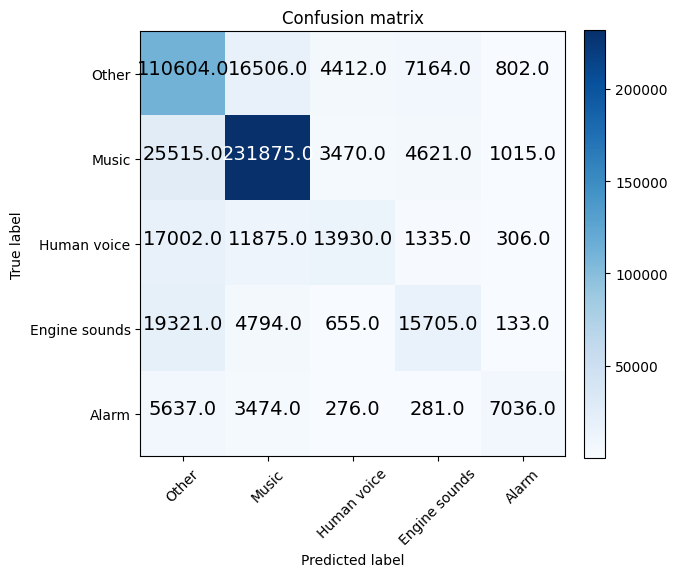

Testing DataLoader 0: 100%|██████████| 15867/15867 [01:35<00:00, 166.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7467345595359802
        test_loss           0.6701021790504456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
results = trainer.test(model, test_loader) # This not the challenge, test set

### Plot Precision Recall curve

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 15867/15867 [00:28<00:00, 558.70it/s]


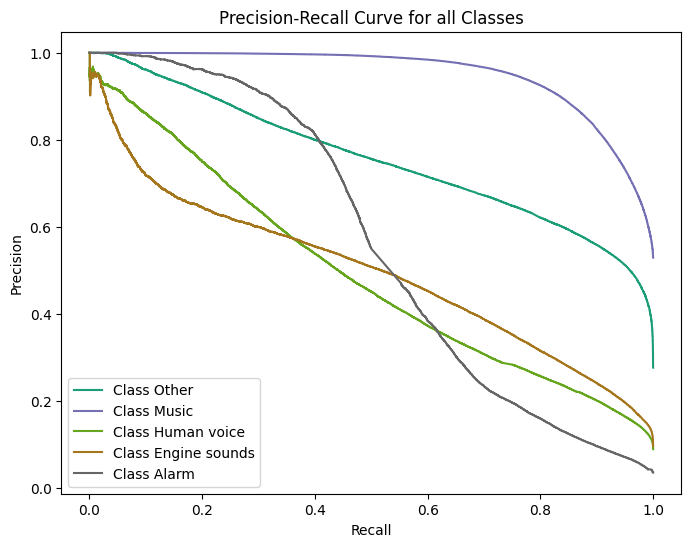

In [ ]:
predictions = trainer.predict(model, test_loader) # This is the challenge, test set

preds = torch.cat([t[0] for t in predictions], dim=0)
target = torch.cat([t[1] for t in predictions], dim=0)

mcprc = torchmetrics.classification.MulticlassPrecisionRecallCurve(num_classes=len(CLASSES), average='macro')
precision, recall, thresholds = mcprc(preds, target)

# plot the precision-recall curves for all classes
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Dark2(np.linspace(0, 1, len(CLASSES)))
for i, color in zip(range(len(CLASSES)), colors):
    ax.plot(recall[i], precision[i], label=f"Class {CLASSES[i]}", color=color)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve for all Classes")
ax.legend()
plt.show()

## Perform predictions on unknown test set

In [ ]:
spectrograms_to_predict = np.load('data/test.npy')

print('Test spectrogram to predict shape:', spectrograms_to_predict.shape)
print('Test spectrogram to predict dtype:', spectrograms_to_predict.dtype)

In [ ]:
test_to_predict_dataset = SpectrogramDataset(spectrograms_to_predict, transform=transforms.ToTensor())
test_to_predict_loader = DataLoader(test_to_predict_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
predictions = trainer.predict(model, test_to_predict_loader)
predictions = np.concatenate(predictions).astype(int)

In [ ]:
np.savetxt('predictions.txt', predictions, delimiter='\n', fmt='%d')